# EOPF: Sentinel‑2 UTM → HEALPix (Level‑1C)

**Audience:** Researchers, Data Scientists
**Last updated:** 2025-15-10

This notebook demonstrates a clear, reproducible workflow to convert Sentinel‑2 L1C data
from its native UTM projection to a global **HEALPix** grid, following the style of the
[EOPF Sentinel‑2 examples].

**You will learn to:**
- Access cloud‑native Sentinel‑2 Zarr data (via STAC/EOPF)
- Subset a region of interest (ROI)
- Attach latitude/longitude coordinates to UTM gridded data
- Reproject/aggregate onto a **HEALPix** equal‑area grid
- Inspect and save the result for downstream analysis

**Prerequisites:** Python, Xarray, familiarity with EO data, basic projections.

> Tip: Run the notebook top‑to‑bottom in a fresh environment for best results.

## Table of Contents

1. [Introduction](#introduction)
2. [Environment & Dependencies](#environment--dependencies)
3. [Data Access via STAC](#data-access-via-stac)
4. [Open the Sentinel‑2 Product](#open-the-sentinel2-product)
5. [Subset a Region of Interest](#subset-a-region-of-interest)
6. [Quicklook & Visualization](#quicklook--visualization)
7. [Add Latitude/Longitude Coordinates](#add-latitudelongitude-coordinates)
8. [Convert to HEALPix](#convert-to-healpix)
9. [Inspect the HEALPix Output](#inspect-the-healpix-output)
10. [Save & Export](#save--export)
11. [Appendix / References](#appendix--references)

## Introduction

Sentinel‑2 Level‑1C products are distributed in **UTM** tiles (projected meters). Many global
analyses benefit from a sphere‑aware, **equal‑area** grid. **HEALPix** (Hierarchical Equal Area
isoLatitude Pixelization) partitions the globe into equal‑area cells, making aggregations and
comparisons consistent across latitudes. This notebook restructures the original workflow with
clear chapters and explanations while preserving all original code and outputs.

This is a **Skelton** Notebook Converting EOPF Zarr format in UTM to HEALPix;
We use EOPF Sample service data here.
Since EOPF data is based on Datatree, we use that property. Thus this workflow can be applied to any UTM expressed EOPF ZARR format. (cf S2L1 and S2L2A)

## Setting up enviroment

In [1]:
try:
    import healpix_geo
except:
    !pip install xarray-eopf  xdggs healpix-geo foscat==2025.10.2 pystac_client

### Imports and setup

- Loads libraries: matplotlib, numpy, xarray. Configures plotting options.

In [2]:
import numpy as np
import pyproj
import pystac_client
import xarray as xr

## Data Access via STAC

We query the EOPF STAC catalog for a suitable Sentinel‑2 L1C item (e.g., low cloud cover, good sun elevation) and obtain the Zarr asset. This keeps the workflow cloud‑native and lazily loaded.

### Open datasets with Xarray


- Opens datasets using Xarray (lazy loading with Dask if chunked).
- To run this notebook with "sentinel-2-l1c", or "sentinel-2-l2a", simply specify it on the collections
-


In [3]:
# Access cloud-optimized Sentinel-2 data via the EOPF STAC catalog
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")

# Define oceanographic study area and time window
LON, LAT = -4.5, 48  # Bay of Biscay - known for consistent wave patterns
date = "2025-06-17/2025-06-17"

# Search criteria optimized for wave analysis

collection = "sentinel-2-l1c"
items = list(
    catalog.search(
        datetime=date,
        collections=[collection],
        intersects=dict(type="Point", coordinates=[LON, LAT]),
        query={
            "eo:cloud_cover": {
                "lt": 20
            },  # Cloud cover < 20% ensures clear ocean surface
            "view:sun_elevation": {
                "gt": 25
            },  # Filter for high sun elevation > 25° (→ sun zenith angle < 65°),
            # which places the sun near the zenith.
        },
    ).items()
)

for item in items:
    print(f"✅ {item.id}")

item = items[0]

✅ S2B_MSIL1C_20250617T112109_N0511_R037_T30UUU_20250617T131418


## Open the Sentinel‑2 Product

We open the product directly as an **Xarray DataTree** (lazy) to navigate measurements, conditions, and multi‑resolution groups (10m/20m/60m).

In [4]:
# Open the dataset lazily from object storage
dt = xr.open_datatree(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
)

dt

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'kerchunk' loading failed:
No module named 'zarr.core.array_spec'; 'zarr.core' is not a package
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


<xarray.DataTree>
Group: /
│   Attributes: (3)
├── Group: /conditions
│   ├── Group: /conditions/geometry
│   │       Dimensions:                        (angle: 2, band: 13, y: 23, x: 23,
│   │                                           detector: 7)
│   │       Coordinates:
│   │         * angle                          (angle) <U7 56B 'zenith' 'azimuth'
│   │         * band                           (band) <U3 156B 'b01' 'b02' ... 'b11' 'b12'
│   │         * detector                       (detector) int64 56B 3 4 5 6 7 8 9
│   │         * x                              (x) int64 184B 300000 305000 ... 410000
│   │         * y                              (y) int64 184B 5400000 5395000 ... 5290000
│   │       Data variables:
│   │           mean_sun_angles                (angle) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
│   │           mean_viewing_incidence_angles  (band, angle) float64 208B dask.array<chunksize=(13, 2), meta=np.ndarray>
│   │           sun_angles                     (angle, y, x) float64 8kB dask.array<chunksize=(2, 23, 23), meta=np.ndarray>
│   │           viewing_incidence_angles       (band, detector, angle, y, x) float64 770kB dask.array<chunksize=(7, 4, 2, 23, 23), meta=np.ndarray>
│   ├── Group: /conditions/mask
│   │   ├── Group: /conditions/mask/detector_footprint
│   │   │   ├── Group: /conditions/mask/detector_footprint/r10m
│   │   │   │       Dimensions:  (y: 10980, x: 10980)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
│   │   │   │         * y        (y) int64 88kB 5399995 5399985 5399975 ... 5290225 5290215 5290205
│   │   │   │       Data variables:
│   │   │   │           b02      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b03      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b04      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   │           b08      (y, x) uint8 121MB dask.array<chunksize=(10980, 10980), meta=np.ndarray>
│   │   │   ├── Group: /conditions/mask/detector_footprint/r20m
│   │   │   │       Dimensions:  (y: 5490, x: 5490)
│   │   │   │       Coordinates:
│   │   │   │         * x        (x) int64 44kB 300010 300030 300050 300070 ... 409750 409770 409790
│   │   │   │         * y        (y) int64 44kB 5399990 5399970 5399950 ... 5290250 5290230 5290210
│   │   │   │       Data variables:
│   │   │   │           b05      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b06      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b07      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b11      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b12      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   │           b8a      (y, x) uint8 30MB dask.array<chunksize=(5490, 5490), meta=np.ndarray>
│   │   │   └── Group: /conditions/mask/detector_footprint/r60m
│   │   │           Dimensions:  (y: 1830, x: 1830)
│   │   │           Coordinates:
│   │   │             * x        (x) int64 15kB 300030 300090 300150 300210 ... 409650 409710 409770
│   │   │             * y        (y) int64 15kB 5399970 5399910 5399850 ... 5290350 5290290 5290230
│   │   │           Data variables:
│   │   │               b01      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │               b09      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   │               b10      (y, x) uint8 3MB dask.array<chunksize=(1830, 1830), meta=np.ndarray>
│   │   └── Group: /conditions/mask/l1c_classification
│   │       └── Group: /conditions/mask/l1c_classification/r60m
│   │               Dimensions:  (y: 1830, x: 18

## Subset a Region of Interest

We extract a small ROI (e.g., a 3×3 window) to demonstrate transformation and HEALPix conversion on a compact example.

In [5]:
# chose small area in UTM
## TODO, we can update here to chose  'one detection' area.

small_dt = dt.sel(
    x=slice(
        dt["conditions"]["geometry"]["sun_angles"].x[0],
        dt["conditions"]["geometry"]["sun_angles"].x[1],
    ),
    y=slice(
        dt["conditions"]["geometry"]["sun_angles"].y[0],
        dt["conditions"]["geometry"]["sun_angles"].y[1],
    ),
)

In [6]:
dt["conditions"]["geometry"]["sun_angles"]

<xarray.DataArray 'sun_angles' (angle: 2, y: 23, x: 23)> Size: 8kB
dask.array<open_dataset-sun_angles, shape=(2, 23, 23), dtype=float64, chunksize=(2, 23, 23), chunktype=numpy.ndarray>
Coordinates:
  * angle    (angle) <U7 56B 'zenith' 'azimuth'
  * x        (x) int64 184B 300000 305000 310000 315000 ... 400000 405000 410000
  * y        (y) int64 184B 5400000 5395000 5390000 ... 5300000 5295000 5290000
Attributes: (1)

## Quicklook & Visualization

We visualize one or more bands (e.g., B02) to confirm the ROI and interpret pixel values before reprojection.

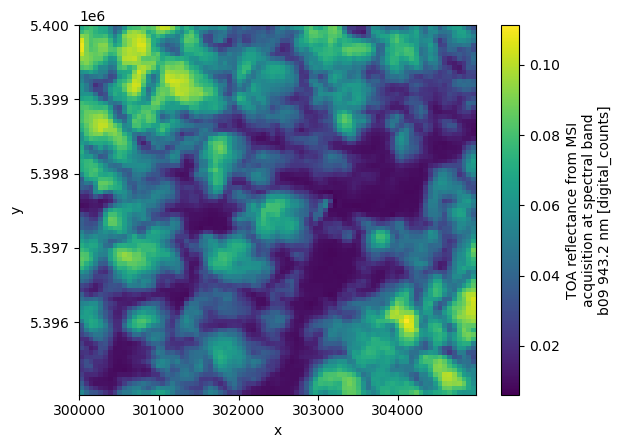

In [7]:
# We see , probably a boat.
# Todo, add plot for small_dt['conditions']['l1c_quicklook']['r10m']
# small_dt['conditions']['l1c_quicklook']['r10m'].hvplot.rgb(x='x',y='y', )

small_dt["measurements"]["reflectance"]["r60m"]["b09"].plot()

## Add Latitude/Longitude Coordinates

Using **pyproj** we transform UTM (x/y in meters) to geographic coordinates (lon/lat in degrees) and attach them as auxiliary coordinates. This enables subsequent binning onto a spherical grid.

### Annotate UTM with latitude and Longitude

In [8]:
def _add_latlon(ds: xr.Dataset, transformer: pyproj.Transformer) -> xr.Dataset:
    """Attach latitude/longitude coords + CF metadata to a Dataset with (x,y)."""
    if not {"x", "y"}.issubset(ds.dims):
        return ds

    xx, yy = np.meshgrid(ds["x"].values, ds["y"].values, indexing="xy")
    lon, lat = transformer.transform(xx, yy)

    ds = ds.assign_coords(
        longitude=(("y", "x"), lon),
        latitude=(("y", "x"), lat),
    )
    ds["latitude"].attrs.update(
        {
            "standard_name": "latitude",
            "long_name": "Latitude",
            "units": "degrees_north",
            "axis": "Y",
        }
    )
    ds["longitude"].attrs.update(
        {
            "standard_name": "longitude",
            "long_name": "Longitude",
            "units": "degrees_east",
            "axis": "X",
        }
    )

    # Make sure vars with (y,x) advertise the aux coords
    for var in ds.data_vars:
        if {"y", "x"}.issubset(ds[var].dims):
            existing = ds[var].attrs.get("coordinates", "").split()
            ds[var].attrs["coordinates"] = " ".join(
                sorted(set(existing) | {"latitude", "longitude"})
            )
    return ds


def add_latlon(
    path: str, ds: xr.Dataset, transformer: pyproj.Transformer
) -> xr.Dataset:
    """Wrapper for safe application on a node dataset."""
    if ds is None:
        print(path, "no dataset")
        return ds
    if not {"x", "y"}.issubset(ds.dims):
        print(path, "not both x,y")
        return ds
    return _add_latlon(ds, transformer)


def add_latlon_to_dt(dt: xr.DataTree) -> xr.DataTree:
    """Return a new DataTree with latitude/longitude coords added everywhere possible."""
    crs_code = dt.attrs["other_metadata"]["horizontal_CRS_code"]
    src_crs = pyproj.CRS.from_string(crs_code)
    transformer = pyproj.Transformer.from_crs(
        src_crs, pyproj.CRS.from_epsg(4326), always_xy=True
    )
    return xr.DataTree.from_dict(
        {
            path: add_latlon(path, node.ds, transformer)
            for path, node in dt.subtree_with_keys
        }
    )

In [9]:
%%time
latlon_dt = add_latlon_to_dt(small_dt)

. not both x,y
conditions not both x,y
measurements not both x,y
quality not both x,y
conditions/mask not both x,y
conditions/meteorology not both x,y
measurements/reflectance not both x,y
quality/l1c_quicklook not both x,y
quality/mask not both x,y
conditions/mask/detector_footprint not both x,y
conditions/mask/l1c_classification not both x,y
conditions/meteorology/cams not both x,y
conditions/meteorology/ecmwf not both x,y
CPU times: user 212 ms, sys: 23 ms, total: 235 ms
Wall time: 233 ms


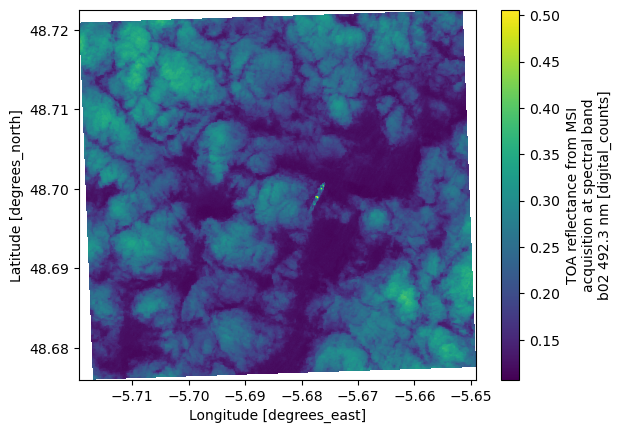

In [10]:
latlon_dt["measurements"]["reflectance"]["r10m"]["b02"].plot(
    x="longitude", y="latitude"
)

In [11]:
import pyproj

crs_code = latlon_dt.attrs["other_metadata"]["horizontal_CRS_code"]

# Option 1: let pyproj parse the whole string
src_crs = pyproj.CRS.from_string(crs_code)

# Option 2: strip the prefix and give only the integer
# src_crs = pyproj.CRS.from_epsg(int(crs_code.split(":")[-1]))

transformer = pyproj.Transformer.from_crs(
    src_crs,
    pyproj.CRS.from_epsg(4326),
    always_xy=True
)

## 5. **Inverse Problem Solution**  

# 📘 Understanding `conjugate_gradient_normal_equation`

This function solves a **least-squares inverse problem** by applying the **Conjugate Gradient (CG)** algorithm to the **normal equations**.  
It is used when you have data on a **UTM grid** (observation space) and want to recover a field on a **HEALPix grid** (solution space).

---

## 🎯 Problem Definition

We want to solve:

$\min_x \frac{1}{2}\| P x - y \|_2^2$

- $y \in \mathbb{R}^m$: observed data on the UTM grid  
- $x \in \mathbb{R}^n$: unknown signal on the HEALPix grid  
- $P$: linear interpolation/projection operator from HEALPix to UTM  

The corresponding **normal equations** are:

$(P^\top P)x = P^\top y$

---

## 🧠 Key Idea

The Conjugate Gradient method solves this system **iteratively** without explicitly forming \(P^\top P\).  
It only requires two operations:

- `LP(x)` ≡ $P x$: project HEALPix data onto UTM grid  
- `LPT(y)` ≡ $P^\top y$: back-project UTM data onto HEALPix grid

---

## 🧰 Parameters

| Parameter       | Meaning                                                                 |
|------------------|-------------------------------------------------------------------------|
| `data` (`y`)     | Observed data on UTM grid                                              |
| `x0`            | Initial guess of solution on HEALPix grid                              |
| `www` (`W`)     | Interpolation weights                                                  |
| `all_idx`       | Indices mapping UTM pixels to contributing HEALPix cells              |
| `LPT`           | Custom adjoint operator \(P^\top\) (optional)                          |
| `LP`            | Custom forward operator \(P\) (optional)                               |
| `max_iter`      | Maximum CG iterations                                                  |
| `tol`           | Convergence tolerance on residual norm                                 |
| `verbose`       | Print progress every 50 iterations                                     |

---

## ⚙️ Default Operators

If you don't provide `LP` or `LPT`, default implementations are used:

- **Forward (`P`)**: interpolate from HEALPix → UTM
```python
P(x) = np.sum(x[indices] * W, axis=0)
```
- **Adjoint (`Pᵗ`)**: back-project from UTM → HEALPix
```python
Pᵗ(y) = np.bincount(indices.flatten(), weights=(W * y[None,:]).flatten()) * hit
```
## 🧠 Key Idea of the Algorithm

Once we have defined the **forward operator** $P$ and its **adjoint** $P^\top$, the goal is to solve the normal equation:

$$(P^\top P)x = P^\top y$$

This system appears naturally in least-squares problems and can be solved iteratively using the **Conjugate Gradient (CG)** method.  
The advantage of CG is that we **never need to explicitly build $P^\top P$**, we only need to apply $P$ and $P^\top$ at each iteration.

---

## 🔁 Conjugate Gradient Workflow

Here is the full CG algorithm applied to our inverse problem:

1. Compute $b = P^\top y$
2. Initialize $x = x_0$ (an initial guess, often zeros)
3. Compute initial residual $r = b - P^\top P x$
4. Set search direction $p = r$
5. For each iteration:
   - Compute $Ap = P^\top P p$
   - Compute step size:  
     $$\alpha = \frac{r^\top r}{p^\top Ap}$$
   - Update the solution:  
     $$x \leftarrow x + \alpha p$$
   - Update the residual:  
     $$r \leftarrow r - \alpha Ap$$
   - Check convergence: stop if $\|r\| < \text{tol}$
   - Update search direction:  
     $$\beta = \frac{r^\top r}{r_{\text{old}}^\top r_{\text{old}}}$$
   - Update $p$:  
     $$p \leftarrow r + \beta p$$

At convergence, $x$ is the solution of the normal equation, and therefore the least-squares solution to the original problem.

---

## 📊 Variable Shapes and Flow

| Variable | Shape | Description |
|----------|-------|-------------|
| `data` ($y$) | $(m,)$ | Observed values on the UTM grid |
| `x` | $(n,)$ | Estimated values on the HEALPix grid |
| `P(x)` | $(m,)$ | Forward projection from HEALPix to UTM |
| `P^\top(y)` | $(n,)$ | Back-projection from UTM to HEALPix |
| `r` | $(n,)$ | Residual vector |
| `p` | $(n,)$ | Search direction |

---

## 📈 Practical Notes

- **Normalization (`hit`)**: Because not all HEALPix cells contribute equally to UTM pixels, we compute a "hit map" to normalize contributions:

  $$\text{hit}[i] = \frac{1}{\text{number of contributions to cell } i}$$

- **Interpretation**:  
  - The forward model $P$ predicts what the UTM measurements would look like for a given HEALPix field $x$.  
  - The adjoint $P^\top$ back-projects errors from UTM space into HEALPix space.  
  - Conjugate Gradient iteratively corrects $x$ to minimize the mismatch.

- **Stopping criterion**:  
  The loop stops when the residual norm $\|r\|$ is below a user-defined tolerance (`tol`).

---

## 🧪 Example Usage

```python
x_est = conjugate_gradient_normal_equation(
    data=utm_values,
    x0=np.zeros(num_healpix_cells),
    www=weights,
    all_idx=indices,
    LP=None,       # custom forward operator (optional)
    LPT=None,      # custom adjoint operator (optional)
    max_iter=200,
    tol=1e-6,
    verbose=True
)
```
This will produce a HEALPix map `x_est` that best fits your UTM observations under the interpolation model 𝑃.

In [12]:
import foscat.SphericalStencil as sc

# Define the convolution width (effective PSF parameter)
# Here: σ = √2
sigma = 1.07 #np.sqrt(2)

def conjugate_gradient_normal_equation(data, x0, www, all_idx, LPT=None, LP=None,
                                       max_iter=100, tol=1e-8, verbose=True):
    """
    Solve the normal equation (Pᵗ P) x = Pᵗ y using the Conjugate Gradient method.
    
    Parameters
    ----------
    data    : array_like
        Observed UTM data y ∈ ℝᵐ
    x0      : array_like
        Initial guess for solution x ∈ ℝⁿ (HEALPix domain)
    www     : interpolation weights
    all_idx : interpolation indices
    LPT     : implementation of adjoint operator Pᵗ
    LP      : implementation of forward operator P
    max_iter: maximum number of CG iterations
    tol     : stopping tolerance on residual norm
    verbose : print convergence info every 50 iterations
    
    Returns
    -------
    x : estimated HEALPix solution u ∈ ℝⁿ
    """

    
    def default_P(x, W, indices):
        """
        Forward operator: P(x) = projection of HEALPix map x onto the UTM grid.

        Steps:
        - Apply spherical convolution with kernel w(x,y).
        - Interpolate from HEALPix cells to UTM pixels using weights W and indices.
        """
        return np.sum(x[indices] * W, 0)

    def default_PT(y, W, indices, hit):
        """
        Adjoint operator: Pᵗ(y) = back-projection from UTM grid to HEALPix cells.
    
        Steps:
        - Distribute UTM values y back onto contributing HEALPix cells using W.
        - Apply hit normalization (inverse of pixel coverage).
        - Apply spherical convolution with kernel w(x,y).
        """
        value = np.bincount(indices.flatten(),weights=(W * y[None,:]).flatten()) * hit
        return value
            
    if LP is None:
        LP = default_P
    if LPT is None:
        LPT = default_PT
    
    x = x0.copy()

    # Compute pixel coverage normalization (hit map)
    hit = np.bincount(all_idx.flatten(), weights=www.flatten())
    hit[hit > 0] = 1 / hit[hit > 0]

    # Compute b = Pᵗ y
    b = LPT(data, www, all_idx, hit)

    # Compute initial residual r = b - A x, with A = Pᵗ P
    Ax = LPT(LP(x, www, all_idx), www, all_idx, hit)
    r = b - Ax

    # Initialize direction
    p = r.copy()
    rs_old = np.dot(r, r)

    for i in range(max_iter):
        # Compute A p = Pᵗ P p
        Ap = LPT(LP(p, www, all_idx), www, all_idx, hit)

        alpha = rs_old / np.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap

        rs_new = np.dot(r, r)

        if verbose and i % 50 == 0:
            print(f"Iter {i:03d}: residual = {np.sqrt(rs_new):.3e}")

        if np.sqrt(rs_new) < tol:
            if verbose:
                print(f"Converged. Iter {i:03d}: residual = {np.sqrt(rs_new):.3e}")
            break

        p = r + (rs_new / rs_old) * p
        rs_old = rs_new

    print(f"Iter {i:03d}: residual = {np.sqrt(rs_new):.3e}")
    return x


## Transforming Gridded Data to a HEALPix Representation

The following cell implements a complete pipeline to **convert geolocated raster data on a Cartesian grid** (with dimensions `x` and `y`) into a **HEALPix-based spherical grid**, which is ideal for global and multi-resolution analysis.

This is a fundamental part of bridging classical satellite data with hierarchical spherical representations used in cosmology and global geoscience.

---

## 📏 1. Choosing the Appropriate HEALPix Resolution

The first step is to decide the HEALPix `level` (or `nside`), which defines the resolution of the spherical grid. The edge length of a HEALPix cell is:

$$
\text{edge}(L) = R \frac{\sqrt{\pi/3}}{2^L}
$$

- $R$ is Earth's radius (≈ 6,371 km).
- $L$ is the HEALPix level (integer).

The function `_choose_healpix_level_from_dx()` estimates the level so that the **HEALPix cell size is not smaller than the input grid spacing** $\Delta x$:

$$
L = \left\lfloor \log_2\left( \frac{R \sqrt{\pi/3}}{\Delta x} \right) \right\rfloor + 1
$$

---

## 🗺️ 2. Converting Coordinates to HEALPix Cell IDs

We convert each pixel’s latitude and longitude to spherical angles:

- $\theta = \frac{\pi}{2} - \varphi_{\text{lat}}$
- $\phi = \varphi_{\text{lon}}$

And then map them to a HEALPix nested index:

$$
\text{cell\_id} = \text{ang2pix}(nside, \theta, \phi, \text{nest=True})
$$

This gives a unique integer for each cell on the sphere.

---

## 📊 3. Grouping Data by HEALPix Cell

Once each pixel is assigned a `cell_id`, we can **group and aggregate** data.  
The grouping depends on the data type and the processing mode:

### 3.1 Simple Averaging (small patches)

If the dataset is small (`< 100` points):

- Stack the data to a 1D vector
- Attach `cell_ids` as a coordinate
- Group by `cell_ids` and compute the mean:

$$
\bar{v}_i = \frac{1}{N_i} \sum_{j \in i} v_j
$$

where $N_i$ is the number of original pixels mapping to HEALPix cell $i$.

---

### 3.2 Mask Merging (bitwise OR)

For mask-like data (e.g. cloud flags), the algorithm merges values using **bitwise OR** per bit:

$$
m_i = \bigvee_{j \in i} m_j
$$

This ensures that any flag present in one pixel is propagated to the HEALPix cell.

---

### 3.3 Interpolation + Inversion (large datasets)

For large datasets, the code performs **spherical convolution** and solves the inverse problem to estimate the HEALPix field $u$ from observed data $d$:

$$
\min_u \| P u - d \|^2
$$

Where:

- $P$ is the forward operator: convolution + interpolation
- $P^\top$ is its adjoint: back-projection

The solution is computed using the **Conjugate Gradient** solver (see previous explanation):

$$
(P^\top P)u = P^\top d
$$

This yields a spatially smoothed HEALPix representation consistent with the observed data.

---

## 🛠️ 4. Updating Metadata and Grid Mapping

Once data is reprojected into HEALPix:

- The `cell_ids` coordinate is added with attributes:
  - `standard_name = "healpix"`
  - `units = "1"`
- A `crs` (grid mapping) variable is added with metadata such as:
  - `grid_mapping_name: healpix`
  - `indexing_scheme: nested`
  - `refinement_level: L`

This ensures full **CF-compliance** and interoperability.

---

## 🌐 5. Converting Entire DataTrees

The function `add_healpix_to_dt()` applies the transformation **recursively** to all groups in a `DataTree`.  

For each dataset:
- It computes the optimal HEALPix level.
- Converts and aggregates the data.
- Updates metadata and adds multi-scale information.

It returns a new `DataTree` with the same group structure, but each group now uses `cell_ids` instead of `(x, y)`.

---

## 📦 Summary of the Workflow

| Step | Function | Purpose |
|------|----------|---------|
| 1 | `_choose_healpix_level_from_dx` | Pick HEALPix resolution from input spacing |
| 2 | `hp.ang2pix` | Map lat/lon → HEALPix cell IDs |
| 3 | `_to_healpix_cells_grouped_mean` | Group and average or solve inverse problem |
| 4 | `_update_group_metadata` | Add CF and grid metadata |
| 5 | `add_healpix_to_dt` | Apply transformation across all groups |

---

✅ **Result**: Your dataset is now in a **HEALPix spherical format**, ready for multi-resolution storage, visualization, and cross-domain analysis (astronomy, geoscience, climate, etc.).


In [13]:
import pathlib
import healpy as hp
#from healpix_geo.nested import lonlat_to_healpix


# --- level selection (coarsest grid not finer than dx) ---
EARTH_RADIUS_M = 6_371_000.0  # radius used in healpix-geo levels table


def _healpix_edge_length_m(level: int, radius_m: float = EARTH_RADIUS_M) -> float:
    # edge = R * sqrt(pi/3) / 2**level  (matches healpix-geo "levels" page)
    return radius_m * np.sqrt(np.pi / 3.0) / (2**level)


def _infer_dx_from_x(ds: xr.Dataset) -> float:
    x = np.asarray(ds["x"].values)
    dx = float(np.nanmedian(np.abs(np.diff(x))))
    if not np.isfinite(dx) or dx <= 0:
        raise ValueError("Could not infer a positive spacing from ds['x'].")
    return dx


def _choose_healpix_level_from_dx(
    ds: xr.Dataset, min_level: int = 0, max_level: int = 29
) -> int:
    dx = _infer_dx_from_x(ds)
    base = EARTH_RADIUS_M * np.sqrt(np.pi / 3.0)
    level = int(np.floor(np.log2(base / dx))) +1 # edge(level) >= dx
    return int(np.clip(level, min_level, max_level))


# --- single-dataset transform -> grouped by unique HEALPix cell_ids ---
def _to_healpix_cells_grouped_mean(
    ds: xr.Dataset, 
    level: int | None = None, 
    ellipsoid: str = "WGS84",
    mask_info: bool = False
) -> xr.Dataset:
    """
    Returns a dataset with dims (angle, cell_ids), where 'cell_ids' is a
    dimension/coordinate containing unique HEALPix ids (NESTED).
    Values are averaged over all source samples that mapped to the same cell.
    """
    if not {"y", "x"}.issubset(ds.dims):
        raise ValueError("Dataset must have 'y' and 'x' dimensions.")
    if not {"latitude", "longitude"}.issubset(ds.coords):
        raise ValueError(
            "Dataset must have 'latitude' and 'longitude' coords (degrees)."
        )

    if level is None:
        level = _choose_healpix_level_from_dx(ds)

    # 1) hash each (lon,lat) to HEALPix nested cell id
    lon = ds["longitude"].values.ravel()
    lat = ds["latitude"].values.ravel()

    # Convert lon/lat to HEALPix spherical angles
    theta = np.deg2rad(90.0 - lat)
    phi   = np.deg2rad(lon)

    nside = 2**level

    if mask_info:
        # Compute interpolation weights and indices for projecting from HEALPix to the UTM grid
        # it is not to use it in the mask computation, but to have the same cell_ids than the other data
        I, W = hp.get_interp_weights(2**level, theta, phi, nest=True)
        
        # Identify the unique HEALPix cells that will contribute to u
        cell_ids, indices = np.unique(I, return_inverse=True)
        
        l_cell_ids = hp.ang2pix(nside,theta,phi,nest=True)

        # Identify the unique HEALPix cells that will contribute to u
        indices = np.searchsorted(cell_ids,l_cell_ids)
        
        o_cell_ids = cell_ids.astype("int64")

        # now I need to merge flags
        N = o_cell_ids.size  # number of HEALPix cells

        cell_dim = "cells"        # name of the new dimension
        cid_name = "cell_ids"    # name of the coordinate storing HEALPix IDs
        
        # 1) Build the 1D Dataset
        data_vars = {}
        for v in ds.data_vars:   
            patch = ds[v].values
            # run your solver to compute values instead of zeros
            vals=np.zeros([N],dtype='uint8')

            for k in range(8):
                vals+=(np.bincount(indices.flatten(),(patch.flatten()>>k)&1,minlength=N)>0).astype('uint8')*2**k
                
            # Each variable must have shape (cell,)
            data_vars[v] = ((cell_dim,), vals)
            
            # 2) Create the Dataset with the HEALPix cell_ids as a coordinate
            out = xr.Dataset(
                data_vars=data_vars,
                coords={cid_name: ((cell_dim,), o_cell_ids)}
            ) 
        
        # 4) Add metadata to the cell_ids coordinate
        out[cid_name].attrs.update({"standard_name": "healpix", "units": "1"})
        
        # 3) Use the cell_ids coordinate as the index of the 'cell' dimension
        out = out.set_index({cell_dim: cid_name})
        
        # 5) Copy global attributes from the original dataset
        out.attrs = dict(ds.attrs)
        # 6) Copy variable-specific attributes from the original dataset
        for v in ds.data_vars:
            out[v].attrs = dict(ds[v].attrs)
        
    elif lon.shape[0]<100: # do not convert with PSF deconv small data
        o_cell_ids = hp.ang2pix(nside,theta,phi,nest=True)
            
        #cell_ids = lonlat_to_healpix(lon, lat, level, ellipsoid=ellipsoid)
        # 2) stack (y,x) -> cells
        out = ds.stack(cells=("y", "x"))
        
        # 3) attach cell_ids coord on 'cells'
        out = out.assign_coords(cell_ids=("cells", o_cell_ids.astype("int64")))
        out["cell_ids"].attrs.update({"standard_name": "healpix", "units": "1"})
        cell_ids_attrs = dict(out["cell_ids"].attrs)  # keep for after groupby
    
        # 4) drop redundant coords/vars
        #    drop_these = [n for n in ("x", "y", "latitude", "longitude") if n in out.variables]
        #    out = out.drop_vars(drop_these)
    
        # 5) group by cell_ids and average
        # **note** This is a very simplified test conversion,
        # later this should be updated spline other interpolation methods.
        out = out.groupby("cell_ids").mean().rename_dims(cell_ids="cells")
        # 6) restore attrs on the new dimension coordinate
        if "cell_ids" in out.coords:
            out["cell_ids"].attrs.update(cell_ids_attrs)
    else:
        # Compute interpolation weights and indices for projecting from HEALPix to the UTM grid
        I, W = hp.get_interp_weights(2**level, theta, phi, nest=True)
        
        # Identify the unique HEALPix cells that will contribute to u
        cell_ids, indices = np.unique(I, return_inverse=True)
    
        # Flatten indices and weights to simplify the following computations
        indices = indices.reshape(4, indices.shape[1])
        W = W.reshape(4, indices.shape[1])
    
        # Initialize the HEALPix convolution operator
        st = sc.SphericalStencil(2**level, 5, cell_ids=cell_ids)
        
        # Define a 5×5 kernel grid centered at (0,0)
        x = np.repeat(np.arange(5) - 2, 5).reshape(5, 5)
        y = x.T
        
        # Build the Gaussian kernel:
        #   w(x,y) = exp(-0.5 * σ² * (x² + y²))
        # The kernel has size 5×5 pixels.
        ww = st.to_tensor(np.exp(-sigma**2 * (x**2 + y**2)).reshape(1, 1, 25))
        
        # Normalize the kernel so that Σ w(x,y) = 1
        ww /= ww.sum()
    
        # Normalize interpolation weights so that they sum to 1 per UTM pixel
        W /= np.sum(W, 0)[None, :]
        # Run the conjugate gradient solver:
        # Solve for HEALPix map u minimizing ||Mu - d||
    
        def l_P(x, W, indices):
            """
            Forward operator: P(x) = projection of HEALPix map x onto the UTM grid.
            
            Steps:
            - Apply spherical convolution with kernel w(x,y).
            - Interpolate from HEALPix cells to UTM pixels using weights W and indices.
            """
            y = st.Convol_torch(st.to_tensor(x.reshape(1,1,cell_ids.shape[0])), ww)
            y = y.cpu().numpy().reshape(cell_ids.shape[0])
            return np.sum(y[indices] * W, 0)
        
        
        def l_PT(y, W, indices, hit):
            """
            Adjoint operator: Pᵗ(y) = back-projection from UTM grid to HEALPix cells.
            
            Steps:
            - Distribute UTM values y back onto contributing HEALPix cells using W.
            - Apply hit normalization (inverse of pixel coverage).
            - Apply spherical convolution with kernel w(x,y).
            """
            value = np.bincount(indices.flatten(),
                                weights=(W * y[None,:]).flatten()) * hit
            return st.Convol_torch(st.to_tensor(value.reshape(1,1,cell_ids.shape[0])), ww)\
                     .cpu().numpy().reshape(cell_ids.shape[0])

        o_cell_ids = cell_ids.astype("int64")
        
        N = o_cell_ids.size  # number of HEALPix cells

        cell_dim = "cells"        # name of the new dimension
        cid_name = "cell_ids"    # name of the coordinate storing HEALPix IDs
        
        # 1) Build the 1D Dataset
        test_rgb=False
        data_vars = {}
        for v in ds.data_vars:
            
            patch = ds[v].values
            if len(patch.shape)>2: # RGB
                test_rgb=True
                
                vals=[]
                for k in range(3):
                    vals.append(conjugate_gradient_normal_equation(
                         patch[k].flatten().astype('float'),
                         np.zeros([N]),
                         W, indices,
                         l_PT, l_P,
                         max_iter=100, verbose=False
                    )[None,...])
                vals=np.vstack(vals).astype('uint8')  
                data_vars[v] = (('band',cell_dim,), vals)
            else:
                # run your solver to compute values instead of zeros
                vals=np.zeros([N])
                vals = conjugate_gradient_normal_equation(
                     patch.flatten(),
                     vals,
                     W, indices,
                     l_PT, l_P,
                     max_iter=100, verbose=False
                )
                # Each variable must have shape (cell,)
                data_vars[v] = ((cell_dim,), vals)
        if test_rgb:
            # 2) Create the Dataset with the HEALPix cell_ids as a coordinate
            out = xr.Dataset(
                data_vars=data_vars,
                coords={'band':np.arange(3),cid_name: ((cell_dim,), o_cell_ids)}
            )
        else:
            # 2) Create the Dataset with the HEALPix cell_ids as a coordinate
            out = xr.Dataset(
                data_vars=data_vars,
                coords={cid_name: ((cell_dim,), o_cell_ids)}
            ) 
        
        # 4) Add metadata to the cell_ids coordinate
        out[cid_name].attrs.update({"standard_name": "healpix", "units": "1"})
        
        # 3) Use the cell_ids coordinate as the index of the 'cell' dimension
        out = out.set_index({cell_dim: cid_name})
        
        # 5) Copy global attributes from the original dataset
        out.attrs = dict(ds.attrs)
        # 6) Copy variable-specific attributes from the original dataset
        for v in ds.data_vars:
            out[v].attrs = dict(ds[v].attrs)

    # 7) keep order stable for variables like (angle, cell_ids)
    #   for v in out.data_vars:
    #       if ("angle" in out[v].dims) and ("cell_ids" in out[v].dims):
    #           out[v] = out[v].transpose("angle", "cell_ids", ...)

    return out


def _update_group_metadata(
    ds: xr.Dataset,
    level: int,
    ellipsoid: str = "WGS84",
    grid_mapping_var_name: str = "crs",
) -> xr.Dataset:
    """Update metadata of a single group."""

    if "cells" not in ds.dims:
        return ds

    ds_healpix = ds.copy()

    # create healpix grid mapping variable
    ds_healpix.coords[grid_mapping_var_name] = (
        (),
        0,
        {
            "grid_mapping_name": "healpix",
            "indexing_scheme": "nested",
            "refinement_ratio": 4,
            "refinement_level": level,
            "reference_body": ellipsoid,
        },
    )

    # update variable attributes
    # dimensions, coordinates and grid_mapping attributes
    # clean-up non-healpix variable attributes
    for var_name, var in ds_healpix.variables.items():
        if "cells" in var.dims:
            attrs = var.attrs.copy()
            eopf_attrs = attrs.get("_eopf_attrs", None)
            if eopf_attrs is not None:
                eopf_attrs["dimensions"] = ["cells"]
                eopf_attrs["coordinates"] = ["cell_ids"]
            for name in var.attrs:
                if "proj:" in name:
                    del attrs[name]
            if "coordinates" in var.attrs:
                attrs["coordinates"] = "cell_ids"
            if var_name != "cell_ids":
                attrs["grid_mapping"] = grid_mapping_var_name
            var.attrs = attrs

    return ds_healpix


# --- HEALPix group converter ---
def _add_healpix_to_group(path: str, ds: xr.Dataset) -> tuple[xr.Dataset, int | None]:
    if ds is None:
        print(path, "no dataset — keeping empty group")
        return xr.Dataset()

    has_xy = {"x", "y"}.issubset(ds.dims)
    has_ll = {"latitude", "longitude"}.issubset(ds.coords)

    if has_xy and not has_ll:
        # stop the whole operation as requested
        raise RuntimeError(
            f"{path}: has x/y but missing latitude/longitude — aborting."
        )

    if has_ll and has_xy:
        level = _choose_healpix_level_from_dx(ds)
        print(
            f"{path}: chosen level {level} (edge≈{_healpix_edge_length_m(level):.4f} m)"
        )
        ds_healpix = _to_healpix_cells_grouped_mean(ds, level=level, ellipsoid="WGS84",mask_info='mask' in path)
        ds_healpix = _update_group_metadata(ds_healpix, level=level, ellipsoid="WGS84")
        return ds_healpix, level

    # no lat/lon -> do nothing
    print(path, "no latitude/longitude — skipping")
    return ds, None


def _update_stac_discovery(attrs: dict):
    """Update product level STAC."""

    # TODO: update "bbox" and "geometry" attributes to
    # so it is consistent with HEALPix cell geometries

    props = attrs["properties"].copy()

    # remove irrelevant properties for HEALPix
    for k in attrs["properties"]:
        if "proj:" in k:
            del props[k]

    # TODO: add STAC discovery "grid:code" property
    # "grid:code" value is formatted like "HEALPIX-I{indexing_scheme}-L{level}-{cell_id}"
    # use a placeholder cell id value for now (to be defined)
    #props["grid:code"] = "HEALPIX-Inested-L10-1234"
    #attrs["stac_extensions"].append(
    #    "https://stac-extensions.github.io/grid/v1.1.0/schema.json"
    #)

    # TODO: update "bbox" and "geometry" attribute values.

    attrs["properties"] = props


# --- public function: apply over the whole DataTree ---
def add_healpix_to_dt(dt: xr.DataTree) -> xr.DataTree:
    """Transform nodes to HEALPix (grouped mean per cell) where possible; preserve others."""

    # HEALPix multiscale attribute convention
    # (inspired from https://github.com/zarr-developers/geozarr-spec/issues/83#issuecomment-3292459330)
    multiscales_attr = {
        "name": "healpix",
        "configuration": {"refinement_ratio": 4},
    }
    multiscale_paths = set()

    # process datatree group by group
    updated_groups = {}
    for path, group in dt.subtree_with_keys:
        path = pathlib.Path(path)
        ds_healpix, level = _add_healpix_to_group(str(path), group.ds)

        # detect multiscale and rename group according to
        # HEALPix refinement level
        if level is not None:
            path = path.parent / str(level)
            multiscale_paths.add(str(path.parent))

        updated_groups[str(path)] = ds_healpix

    dt_healpix = xr.DataTree.from_dict(updated_groups, name=getattr(dt, "name", None))

    # add multiscale metadata
    for path, group in dt_healpix.subtree_with_keys:
        if path in multiscale_paths:
            group.attrs["multiscales"] = multiscales_attr

    # update product level metadata
    _update_stac_discovery(dt_healpix.attrs["stac_discovery"])

    return dt_healpix


# Compute ONE patch from ONE UTM tile

## Extracting and Converting a Subdomain to HEALPix: `get_sub_pieces`

The function `get_sub_pieces()` is a utility designed to **extract a spatial subset** of a larger dataset (stored as a `DataTree` or `Dataset`), **augment it with geolocation information**, and **convert it to a HEALPix representation**.  
It is particularly useful when dealing with large satellite scenes or model outputs where we want to process only a smaller region at a time.

---

## 🧭 Function Workflow

### 1. **Spatial Subsetting**

```python
small_dt = dt.sel(
    x=slice(x_beg, x_end),
    y=slice(y_beg, y_end),
)


In [14]:
def get_sub_pieces(dt,x_beg,x_end,y_beg,y_end):
    small_dt = dt.sel(
        x=slice(x_beg,x_end),y=slice(y_beg,y_end),
    )
    latlon_dt = add_latlon_to_dt(small_dt)

    # Convert the whole tree
    return add_healpix_to_dt(latlon_dt)

# Incremental Zarr Merge (any variable shape with `cells`): `rewrite_group_with_insert_anydim`

This function merges a **patch `xarray.Dataset`** into an **existing Zarr group** when variables include a `cells` dimension (e.g. `(cells,)`, `(band, cells)`, `(cells, angle)`, etc.).  
It **unions and sorts** HEALPix cell IDs, then merges each variable **element-wise**:
- `uint8` masks → **bitwise OR**
- numeric types → **average** on overlaps (integers are rounded back)

Only arrays that **depend on `cells`** (and the `cells` coordinate itself) are replaced; all other variables in the group are preserved.

---

## Function Signature

```python
def rewrite_group_with_insert_anydim(
    zarr_path: str,
    group_path: str,
    ds_patch: xr.Dataset,
    *,
    cell_dim: str = "cells",
) -> None:
    ...
```
# 📚 Documentation: `rewrite_group_with_insert_anydim`

This section explains in detail how the function `rewrite_group_with_insert_anydim` works, how to use it, and the exact steps it performs when merging a patch `Dataset` into a Zarr group.

---

## 📌 Parameters

| Name | Type | Description |
|------|------|-------------|
| `zarr_path` | `str` | Path to the Zarr store |
| `group_path` | `str` | Path to the group within the store (e.g., `"measurements/reflectance/20"`) |
| `ds_patch` | `xr.Dataset` | Patch dataset containing new/updated values. It must expose a `cells` coordinate of type `int64`. |
| `cell_dim` | `str` | Name of the HEALPix index dimension (default: `"cells"`) |

---

## 🧠 What It Does (Step-by-Step)

### 1. Normalize the patch
- Ensures that `ds_patch` has a coordinate named `cells` of type `int64`.
- If `cells` is present only as a dimension, it is promoted to a coordinate.

### 2. Open the target group
- The function loads the existing Zarr group using `xr.open_zarr(..., consolidated=False)` to retrieve variables, dimensions, and metadata.

### 3. Compute the union index
- Let `old_cells` be the existing cell indices and `new_cells` be those from the patch.
- Compute the merged index:
  ```python
  all_cells = np.union1d(old_cells, new_cells)
  ```

# 🔄 Detailed Explanation: Variable Merging in `rewrite_group_with_insert_anydim`

This section explains how the merging process works when updating Zarr groups with new `cells` data — including step-by-step logic, merge rules, data flow, and best practices.

---

## 1. Compute Union Index and Position Maps

After determining the union of all cell indices:
    ```python
    all_cells = np.union1d(old_cells, new_cells)
    ```
map the position of each old and new cell in the merged array:
    ```python
    pos_old = np.searchsorted(all_cells, old_cells)
    pos_new = np.searchsorted(all_cells, new_cells)
    ```

These position arrays allow us to correctly align old and new data along the new common `cells` dimension.

---

## 2. Merge Variables Containing `cells`

For each variable in the group that:
- has `cells` among its dimensions, and
- is present in the patch,

perform the steps below.

### 2.1 Bring the `cells` axis to the front

Move the `cells` axis to the front to simplify indexing operations:

```python
    a_old0 = np.moveaxis(old_array, cells_axis, 0)
    a_new0 = np.moveaxis(new_array, cells_axis, 0)
```

### 2.2 Create buffers for merged data

Prepare two buffers with the size of the union of cells (`all_cells`):

```python
    buf_old = np.zeros((len(all_cells), ...))
    buf_new = np.zeros((len(all_cells), ...))
```

### 2.3 Fill buffers at correct positions

- Old data is written at positions `pos_old`
- New data is written at positions `pos_new`

This ensures correct alignment in the merged index space.

### 2.4 Merge according to data type

- If `dtype == uint8`: perform an element-wise bitwise OR.
- Otherwise: compute an element-wise average where both values exist; if only one exists, keep that one.

### 2.5 Restore original axis order

After merging, move the `cells` axis back to its original position to restore the variable’s original shape.

---

## 3. Preserve Non-`cells` Variables

Variables that do not depend on the `cells` dimension are copied unchanged into the merged dataset. This ensures that unrelated metadata and static variables remain intact.

---

## 4. Rewrite Only Affected Arrays

Replace only the arrays that were updated:
- Delete affected arrays and the `cells` coordinate using the Zarr low-level API.
- Write the merged dataset back to the same group.

This avoids rewriting the entire store and speeds up the process significantly.

---

## Merge Rules

For each cell index $i$ and any fixed set of other dimensions:

### Numeric variables

$ v_{\text{out}}[i] =
\begin{cases}
\frac{v_{\text{old}}[i] + v_{\text{new}}[i]}{2}, & \text{if both exist} \\
v_{\text{new}}[i], & \text{if only new exists} \\
v_{\text{old}}[i], & \text{if only old exists}
\end{cases}
$

### Mask (`uint8`)

$ m_{\text{out}}[i] = m_{\text{old}}[i] \ \texttt{OR}\ m_{\text{new}}[i] $

---

## Data Flow Overview

```python
    Existing Zarr group (xarray view)
        ├── read dims/coords/vars
        └── old_cells (int64)

    Patch Dataset
        └── new_cells (int64)

    Union index
        └── all_cells = sorted(unique(old_cells ∪ new_cells))

    Per variable with 'cells' in dims:
        ├── align old/new to all_cells (cells axis to front)
        ├── merge (OR for uint8, average for numeric)
        └── restore original axis order

    Rewrite group:
        ├── delete affected arrays + 'cells' coord
        └── write merged Dataset back to the same group
```

---

## Usage Example

Example: merge a patch dataset with the same variable names as in the store. Each variable must include `cells` somewhere in its dims, e.g., `(band, cells)`.

```python
    ds_patch = xr.Dataset(
        data_vars=dict(
            b02=(("band", "cells"), patch_b02_values),
            b03=(("band", "cells"), patch_b03_values),
        ),
        coords=dict(
            band=patch_band_labels,
            cells=patch_cell_ids.astype("int64"),
        ),
    )

    rewrite_group_with_insert_anydim(
        zarr_path="collection_healpix.zarr",
        group_path="measurements/reflectance/20",
        ds_patch=ds_patch,
        cell_dim="cells",
    )
```

Optional (if you plan to read with `consolidated=True`), reconsolidate metadata after merging:

```python
    import zarr
    zarr.consolidate_metadata("collection_healpix.zarr")
```

---

## Notes & Best Practices

### Dimension label consistency
For non-`cells` dimensions (e.g., `band`, `angle`), the function assumes identical labels and order in both the store and the patch. If they might differ, align them manually:

```
    ds_patch = ds_patch.transpose(*ds_store[name].dims)
```

or reindex by coordinates before merging.

### Consolidated metadata
If you intend to open the Zarr store with `consolidated=True`, make sure to reconsolidate metadata after merging:

```python
    import zarr
    zarr.consolidate_metadata(zarr_path)
```

### Performance considerations
- The function reconstructs merged arrays in memory per variable.
- Only the updated arrays are rewritten to the Zarr store.
- This minimizes I/O overhead and ensures consistent data alignment.

### Why not insert in-place?
Zarr does not support inserting data arbitrarily in the middle of arrays using boolean or advanced indexing. Shifting blocks across variables would be complex and error-prone. Building merged arrays in memory and writing them back is safer, faster, and more reliable for large datasets.

In [15]:
import numpy as np
import xarray as xr
import zarr
from typing import Iterable

def _is_mask_uint8(da: xr.DataArray) -> bool:
    return np.dtype(da.dtype) == np.uint8

def _swap_cells_front(a: np.ndarray, axis: int) -> np.ndarray:
    """Move axis `axis` to the front (axis 0)."""
    return np.moveaxis(a, axis, 0)

def _swap_cells_back(a0: np.ndarray, axis: int) -> np.ndarray:
    """Move axis 0 back to `axis`."""
    return np.moveaxis(a0, 0, axis)

def rewrite_group_with_insert_anydim(
    zarr_path: str,
    group_path: str,
    ds_patch: xr.Dataset,
    *,
    cell_dim: str = "cells",
) -> None:
    """
    Merge a patch Dataset into an existing Zarr group (any dims containing `cells`).

    Rules:
      - Union-sort cell ids (int64).
      - For each variable that includes `cells` in its dims:
          * if dtype == uint8 -> bitwise OR on overlaps (element-wise),
          * else -> numeric average on overlaps (float; integers rounded back).
      - Variables in the group that do NOT use `cells` are kept as-is.
      - Only the affected arrays and the coord `cells` are replaced.

    The patch must provide the same variable names you want to merge.
    Extra dims (like band/angle/detector) must have the same labels/order in store and patch.
    """
    mapper = fsspec.get_mapper(
        zarr_path,
        key=os.environ["AWS_ACCESS_KEY_ID"],
        secret=os.environ["AWS_SECRET_ACCESS_KEY"],
        token=os.environ.get("AWS_SESSION_TOKEN"),
        client_kwargs={"endpoint_url": "https://pangeo-eosc-minioapi.vm.fedcloud.eu"},
        config_kwargs={"s3": {"addressing_style": "path"}},
    )
    
    # Normalize patch: ensure `cells` coord and int64
    if cell_dim not in ds_patch.coords and cell_dim in ds_patch.dims:
        ds_patch = ds_patch.assign_coords({cell_dim: (cell_dim, ds_patch[cell_dim].values)})
    if cell_dim not in ds_patch.coords:
        raise ValueError("patch Dataset must expose a coord named `cells`.")
    ds_patch = ds_patch.assign_coords({cell_dim: ds_patch[cell_dim].astype("int64")})

    # Open existing group (xarray for metadata/dims, zarr for low-level deletes)
    ds_store = xr.open_zarr(mapper, group=group_path, consolidated=False)
    old_cells = ds_store[cell_dim].values.astype(np.int64)

    # Variables to merge = all vars that include `cells` in their dims and are present in patch
    vars_with_cells: list[str] = [
        k for k, v in ds_store.data_vars.items()
        if (cell_dim in v.dims) and (k in ds_patch.data_vars)
    ]
    if not vars_with_cells:
        # Nothing to merge for this group, but we still may need to add cells
        # If the group is empty or patch has no matching vars, bail gracefully.
        return

    # Compute new union index
    new_cells = ds_patch[cell_dim].values.astype(np.int64)
    all_cells = np.union1d(old_cells, new_cells)
    n_all = all_cells.size

    # Position maps
    pos_old = np.searchsorted(all_cells, old_cells)
    pos_new = np.searchsorted(all_cells, new_cells)

    # Build merged Dataset in memory (only the variables that include `cells`)
    merged_vars = {}
    merged_coords = {cell_dim: (cell_dim, all_cells)}

    for name in vars_with_cells:
        da_old = ds_store[name]
        da_new = ds_patch[name]

        # Sanity: same other dims (labels & order) between old & new
        if set(da_old.dims) != set(da_new.dims):
            raise ValueError(
                f"{group_path}/{name}: dims mismatch between store {da_old.dims} and patch {da_new.dims}"
            )
        # We'll assume identical labels/orders for non-`cells` dims.
        # If needed, you can align: da_new = da_new.transpose(*da_old.dims)

        axis_old = da_old.get_axis_num(cell_dim)  # cells axis in this var
        axis_new = da_new.get_axis_num(cell_dim)

        # Bring cells to front
        a_old0 = _swap_cells_front(np.asarray(da_old.values), axis_old)  # shape: (n_old, *tail)
        a_new0 = _swap_cells_front(np.asarray(da_new.values), axis_new)  # shape: (n_new, *tail)

        tail_shape = a_old0.shape[1:]  # same tail expected

        # Prepare working buffers with cells-first
        if _is_mask_uint8(da_old):
            # uint8 mask -> OR merge
            buf_old = np.zeros((n_all,) + tail_shape, dtype=np.uint8)
            buf_new = np.zeros((n_all,) + tail_shape, dtype=np.uint8)
            buf_old[pos_old, ...] = a_old0.astype(np.uint8, copy=False)
            buf_new[pos_new, ...] = a_new0.astype(np.uint8, copy=False)

            out0 = np.bitwise_or(buf_old, buf_new)

            out = _swap_cells_back(out0, axis_old).astype(np.uint8, copy=False)

        else:
            # numeric merge -> average on overlaps
            # Work in float64 to handle NaNs and averaging, then cast back.
            f_old = np.full((n_all,) + tail_shape, np.nan, dtype=np.float64)
            f_new = np.full((n_all,) + tail_shape, np.nan, dtype=np.float64)

            f_old[pos_old, ...] = a_old0.astype(np.float64, copy=False)
            f_new[pos_new, ...] = a_new0.astype(np.float64, copy=False)

            has_old = np.isfinite(f_old)
            has_new = np.isfinite(f_new)

            out0 = np.where(
                has_old & has_new, (f_old + f_new) / 2.0,
                np.where(has_new, f_new, f_old)
            )

            # cast back to original dtype
            if np.issubdtype(da_old.dtype, np.integer):
                out = _swap_cells_back(np.rint(out0).astype(da_old.dtype, copy=False), axis_old)
            else:
                out = _swap_cells_back(out0.astype(da_old.dtype, copy=False), axis_old)

        merged_vars[name] = (da_old.dims, out)

    ds_merged = xr.Dataset(merged_vars, coords=merged_coords)

    # Keep other (non-cells) variables untouched
    others = [k for k, v in ds_store.data_vars.items() if cell_dim not in v.dims]
    if others:
        ds_merged = xr.merge([ds_merged, ds_store[others]])

    # Replace arrays in Zarr for this group: drop affected arrays + coord, then write
    root = zarr.open(mapper, mode="a")
    g = root
    for p in group_path.strip("/").split("/"):
        if p:
            g = g.require_group(p)
    for name in vars_with_cells:
        if name in g:
            del g[name]
    if cell_dim in g:
        del g[cell_dim]

    ds_merged.to_zarr(mapper, group=group_path, mode="a")
    # Optionally consolidate after many merges (outside this function).

# 📘 Documentation: `merge_datatree_anydim_into_zarr`

## 🧠 Purpose

The function `merge_datatree_anydim_into_zarr` is designed to **merge all HEALPix groups** from an `xarray.DataTree` into a Zarr store.  
It uses the lower-level function `rewrite_group_with_insert_anydim` to handle merging **any variable whose dimensions include the `cells` dimension**, such as:

- `(cells,)`
- `(band, cells)`
- `(cells, angle)`
- `(band, cells, angle)`

It is a generalized version of `merge_datatree_1d_into_zarr` and works for multidimensional data.

---

## 🧰 Function Signature

```python
def merge_datatree_anydim_into_zarr(
    dt: xr.DataTree,
    zarr_path: str,
    *,
    cell_dim: str = "cells",
    consolidate_after: bool = False
) -> List[str]:
```

### Parameters

| Name | Type | Description |
|------|------|-------------|
| **dt** | `xr.DataTree` | The input DataTree containing one or more datasets (groups) to be merged. |
| **zarr_path** | `str` | Path to the target Zarr store on disk. |
| **cell_dim** | `str` | Name of the dimension representing HEALPix cells (default: `"cells"`). |
| **consolidate_after** | `bool` | If `True`, consolidates Zarr metadata after merging. Recommended when planning to read with `consolidated=True`. |

---

## 🔄 Workflow Explained

### 1. Iterate Over All Groups

The function loops through **every group (node)** inside the `DataTree`:

```python
for path, node in dt.subtree_with_keys:
```
- `path`: the hierarchical group path (e.g., `"measurements/reflectance/20"`)
- `node.ds`: the `xarray.Dataset` contained in that group.

It skips groups that:
- are empty,
- or do not contain any data variables.

---

### 2. Ensure a HEALPix Index

Each dataset must include a coordinate or dimension that represents the HEALPix cell index.  
The function checks for `cells`:

```python
if cell_dim not in ds.coords and cell_dim not in ds.dims:
    if "cell_ids" in ds.coords:
        ds = ds.rename({"cell_ids": cell_dim})
    elif "cell_ids" in ds.dims:
        ds = ds.rename_dims({"cell_ids": cell_dim}).rename_vars({"cell_ids": cell_dim})
    else:
        continue  # skip group if no healpix index
```

- If the dataset has `cell_ids`, it is renamed to `cells`.
- If it does not contain a cell dimension at all → group is **skipped**.

The coordinate is also normalized to `int64`:

```python
ds = ds.assign_coords({cell_dim: ds[cell_dim].astype("int64")})
```

---

### 3. Filter Variables with `cells`

The merging process only applies to variables that **depend on `cells`**.  
This is done by filtering:

```python
vars_with_cells = [k for k, v in ds.data_vars.items() if cell_dim in v.dims]
```

If no such variable exists, the group is ignored.

---

### 4. Build the Patch Dataset

We now construct a minimal patch dataset containing **only the relevant variables**:

```python
ds_patch = ds[vars_with_cells]
```

---

### 5. Merge the Dataset into the Zarr Store

The heavy lifting is done by calling:

```python
rewrite_group_with_insert_anydim(
    zarr_path=zarr_path,
    group_path=group_path,
    ds_patch=ds_patch,
    cell_dim=cell_dim,
)
```

- It merges the dataset **into the correct group** inside the Zarr store.
- Handles **union-sorting of cell indices**, **bitwise OR** for masks, and **numeric averaging** for overlapping values.

---

### 6. Optional: Consolidate Metadata

If `consolidate_after=True`, the function consolidates Zarr metadata:

```python
import zarr
zarr.consolidate_metadata(zarr_path)
```

This is useful if you want to open the Zarr store later with:

```python
xr.open_zarr(zarr_path, consolidated=True)
```

---

## 📊 Merge Behavior

For each variable with dimension `cells`, the following merge rules apply:

- **Numeric data**: averaged on overlapping cells.
- **Mask (uint8)**: combined with element-wise bitwise OR.
- **Non-cell variables**: remain unchanged.

Mathematically, for each cell index $i$:

- **Numeric variables:**

$
v_{	ext{out}}[i] =
egin{cases}
rac{v_{	ext{old}}[i] + v_{	ext{new}}[i]}{2}, & 	ext{if both exist} \\
v_{	ext{new}}[i], & 	ext{if only new exists} \\
v_{	ext{old}}[i], & 	ext{if only old exists}
\end{cases}
$

- **Mask variables:**

$
m_{	ext{out}}[i] = m_{	ext{old}}[i] \ 	exttt{OR}\ m_{	ext{new}}[i]
$

---

## 📦 Return Value

- Returns a `List[str]` of all merged group paths.
- Each path corresponds to a group in the Zarr store that was updated.

---

## ✅ Example Usage

```python
merged_groups = merge_datatree_anydim_into_zarr(
    dt=my_datatree,
    zarr_path="collection_healpix.zarr",
    cell_dim="cells",
    consolidate_after=True
)

print("Merged groups:", merged_groups)
```

---

## 🧪 Notes & Best Practices

- ✅ **Dimension consistency:** Non-`cells` dimensions (e.g., `band`, `angle`) must match in labels and order between patch and store.
- ✅ **Efficient merging:** Only variables that include `cells` are rewritten — the rest of the dataset remains unchanged.
- ⚠️ **No in-place mid-array insert:** Zarr does not support inserting data in the middle of an array. The function rebuilds aligned arrays in memory before writing.

---

## 📁 Summary

| Feature | Description |
|--------|-------------|
| 🔄 Merge | Any variable with `cells` in its dims |
| 📦 Input | `xarray.DataTree` |
| 💾 Output | Updated Zarr store |
| ⚙️ Merge mode | Bitwise OR (uint8), average (numeric) |
| 🧹 Optional | Metadata consolidation |

This function is essential when dealing with **large hierarchical HEALPix datasets** that evolve over time — allowing you to **incrementally merge** new observations or partial updates without rewriting the entire store.

In [16]:
from typing import List

def merge_datatree_anydim_into_zarr(
    dt: xr.DataTree,
    zarr_path: str,
    *,
    cell_dim: str = "cells",
    consolidate_after: bool = False
) -> List[str]:
    """
    Merge all HEALPix groups from a DataTree into a Zarr store using
    `rewrite_group_with_insert_anydim`, covering variables with dims that include `cells`
    (e.g. (cells,), (band,cells), (cells,angle), etc.).

    Groups without `cells` are skipped.
    """
    mapper = fsspec.get_mapper(
        zarr_path,
        key=os.environ["AWS_ACCESS_KEY_ID"],
        secret=os.environ["AWS_SECRET_ACCESS_KEY"],
        token=os.environ.get("AWS_SESSION_TOKEN"),
        client_kwargs={"endpoint_url": "https://pangeo-eosc-minioapi.vm.fedcloud.eu"},
        config_kwargs={"s3": {"addressing_style": "path"}},
    )

    merged_groups: List[str] = []

    for path, node in dt.subtree_with_keys:
        ds = getattr(node, "ds", None)
        if not isinstance(ds, xr.Dataset) or len(ds.data_vars) == 0:
            continue

        # Ensure we have a HEALPix index
        if cell_dim not in ds.coords and cell_dim not in ds.dims:
            if "cell_ids" in ds.coords:
                ds = ds.rename({"cell_ids": cell_dim})
            elif "cell_ids" in ds.dims:
                ds = ds.rename_dims({"cell_ids": cell_dim}).rename_vars({"cell_ids": cell_dim})
            else:
                # no healpix index -> skip
                continue

        if cell_dim not in ds.coords or ds[cell_dim].dims != (cell_dim,):
            ds = ds.assign_coords({cell_dim: (cell_dim, ds[cell_dim].values)})
        ds = ds.assign_coords({cell_dim: ds[cell_dim].astype("int64")})

        # Keep only variables that use `cells` somewhere in their dims
        vars_with_cells = [k for k, v in ds.data_vars.items() if cell_dim in v.dims]
        if not vars_with_cells:
            continue

        ds_patch = ds[vars_with_cells]  # only the variables we can merge

        group_path = str(path).strip("/") or "/"
        rewrite_group_with_insert_anydim(
            zarr_path=zarr_path,
            group_path=group_path,
            ds_patch=ds_patch,
            cell_dim=cell_dim,
        )
        merged_groups.append(group_path)
        print(f"[merged] {group_path}: cells={ds_patch.sizes[cell_dim]} vars={len(vars_with_cells)}")

    if consolidate_after:
        import zarr
        zarr.consolidate_metadata(mapper)

    return merged_groups


# 🧩 Chunk-by-Chunk Conversion and Merge into Zarr

This code block builds a HEALPix Zarr store by **processing the dataset piece by piece** and **merging the results incrementally**.  
It’s designed to handle large datasets that cannot be converted all at once in memory.

## 🧠 Step-by-Step Explanation

### 1. 📁 Define the Zarr Output Path

```python
zstore = collection + "_healpix.zarr"
```

- This sets the output path for the final HEALPix data.
- `collection` is a base string (e.g., dataset name), and `"_healpix.zarr"` is appended to indicate the store format.

---

### 2. 🔁 Initialize a Write-Once Flag

```python
zarr_exist = False
```

- This boolean variable tracks whether the Zarr store already exists.
- It ensures the store is **created once** and **updated afterward**.

---

### 3. 🧱 Loop Over Data Chunks

```python
for k in range(3):
    for l in range(3):
```
- This double loop divides the spatial domain into **3 × 3 tiles**.
- Each iteration processes a smaller subset of the data, avoiding memory overload.

---

### 4. 📉 Extract a Subset of the DataTree

```python
local_dt = get_sub_pieces(
    dt,
    dt["conditions"]["geometry"]["sun_angles"].x[k],
    dt["conditions"]["geometry"]["sun_angles"].x[k+1],
    dt["conditions"]["geometry"]["sun_angles"].y[l],
    dt["conditions"]["geometry"]["sun_angles"].y[l+1]
)
```

- `get_sub_pieces()` slices the full `dt` DataTree spatially, creating a small DataTree `local_dt` for one region.
- This subset is immediately converted to HEALPix format internally.
- By processing chunks, the pipeline scales to **very large global datasets**.

---

### 5. ✍️ Create or Merge the Zarr Store

Two cases are handled differently:

#### 🆕 First Iteration – Create the Zarr Store

```python
if not zarr_exist:
    local_dt.to_zarr(zstore, mode="w")
    zarr_exist = True
```

- The first subset writes a **new Zarr dataset** from scratch (`mode="w"` overwrites existing data).
- After this, the store exists, and the merge mode will be used.

---

#### 🔄 Subsequent Iterations – Merge into Existing Zarr

```python
else:
    merged = merge_datatree_anydim_into_zarr(
        local_dt,
        zarr_path=zstore,
        cell_dim="cells",
        consolidate_after=True
    )
```

- Every subsequent chunk is **merged** into the existing store.
- `merge_datatree_anydim_into_zarr()` handles:
  - Finding common HEALPix `cells` between old and new data.
  - Averaging numeric overlaps or applying bitwise OR to masks.
  - Appending new cells efficiently.
- `consolidate_after=True` updates the metadata index so future reads with `consolidated=True` remain valid.

---

## 📊 Workflow Summary

```
┌────────────────────────────┐
│ 1️⃣ Define Zarr path       │
│ 2️⃣ Initialize zarr_exist  │
│ 3️⃣ Loop over subregions   │
│ 4️⃣ Extract local DataTree │
│ 5️⃣ First → write store   │
│ 6️⃣ Others → merge chunks │
└────────────────────────────┘
```

---

## ✅ Why This Approach?

- **Memory efficient**: avoids loading the entire dataset.
- **Scalable**: handles very large spatial data by incremental processing.
- **Safe merging**: ensures existing data is not overwritten but correctly updated.
- **Metadata-ready**: can be read later with `xr.open_datatree(..., consolidated=True)`.

---

## 📌 Best Practices

- Choose chunk sizes (`3×3` here) according to your memory limits and spatial resolution.
- Always reconsolidate metadata if planning to read with `consolidated=True`.
- Ensure that variable names and dimensions are consistent across chunks.


In [ ]:
import os, s3fs
import fsspec, zarr
from dotenv import load_dotenv

#load ACCESS_KEY,SECRET_KEY
load_dotenv()  # get env variable

zstore = "s3://group-01-private/"+ collection + "_healpix.zarr"
mapper = fsspec.get_mapper(
    zstore,
    key=os.environ["AWS_ACCESS_KEY_ID"],
    secret=os.environ["AWS_SECRET_ACCESS_KEY"],
    token=os.environ.get("AWS_SESSION_TOKEN"),
    client_kwargs={"endpoint_url": "https://pangeo-eosc-minioapi.vm.fedcloud.eu"},
    config_kwargs={"s3": {"addressing_style": "path"}},
)

# écriture

zarr_exist=False

n_step=2 # 2x2 means about 10GB of memory 25GB GPU
beg_x = [k for k in range(0,dt["conditions"]["geometry"]["sun_angles"].x.shape[0],n_step)]
end_x = [
    k + n_step if k + n_step <= dt["conditions"]["geometry"]["sun_angles"].x.shape[0] 
    else dt["conditions"]["geometry"]["sun_angles"].x.shape[0] 
    for k in range(0, dt["conditions"]["geometry"]["sun_angles"].x.shape[0], n_step) 
]
beg_y = [k for k in range(0,dt["conditions"]["geometry"]["sun_angles"].y.shape[0],n_step)]
end_y = [
    k + n_step if k + n_step <= dt["conditions"]["geometry"]["sun_angles"].y.shape[0] 
    else dt["conditions"]["geometry"]["sun_angles"].y.shape[0] 
    for k in range(0, dt["conditions"]["geometry"]["sun_angles"].y.shape[0], n_step)
]

for k in range(len(beg_x)):
    for l in range(len(beg_y)):
    
        local_dt = get_sub_pieces(dt,dt["conditions"]["geometry"]["sun_angles"].x[beg_x[k]],
                                dt["conditions"]["geometry"]["sun_angles"].x[end_x[k]],
                                dt["conditions"]["geometry"]["sun_angles"].y[beg_y[l]],
                                dt["conditions"]["geometry"]["sun_angles"].y[end_y[l]])
        
        if zarr_exist:
            # Merge every HEALPix group from your DataTree (1D and multi-dim)
            merged = merge_datatree_anydim_into_zarr(
                local_dt,
                zarr_path=zstore,
                cell_dim="cells",
                consolidate_after=True,   # consolidate if you read with consolidated=True
            )
        else:
            local_dt.to_zarr(mapper, mode="w")
            zarr_exist=True

. not both x,y
conditions not both x,y
measurements not both x,y
quality not both x,y
conditions/mask not both x,y
conditions/meteorology not both x,y
measurements/reflectance not both x,y
quality/l1c_quicklook not both x,y
quality/mask not both x,y
conditions/mask/detector_footprint not both x,y
conditions/mask/l1c_classification not both x,y
conditions/meteorology/cams not both x,y
conditions/meteorology/ecmwf not both x,y
. no latitude/longitude — skipping
conditions no latitude/longitude — skipping
measurements no latitude/longitude — skipping
quality no latitude/longitude — skipping
conditions/geometry: chosen level 11 (edge≈3183.4055 m)
conditions/mask no latitude/longitude — skipping
conditions/meteorology no latitude/longitude — skipping
measurements/reflectance no latitude/longitude — skipping
quality/l1c_quicklook no latitude/longitude — skipping
quality/mask no latitude/longitude — skipping
conditions/mask/detector_footprint no latitude/longitude — skipping
conditions/mask/l

## Appendix / References

- EOPF Sample Notebooks (Sentinel‑2): examples of structure and style for cloud‑native EO workflows.
- HEALPix: Górski et al., 2005. *ApJ* 622, 759–771.
- PyProj/PROJ: Coordinate transforms between projected and geographic systems.
- Xarray DataTree: Hierarchical datasets for multi‑group EO products.
